In [1]:
# Importing necessary libraries
import tensorflow as tf
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
import numpy as np
import cv2
import os
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt

In [2]:
# Load the pre-trained VGG16 model + higher level layers
base_model = VGG16(weights='imagenet')
model = Model(inputs=base_model.input, outputs=base_model.get_layer('fc1').output)

In [3]:
# Function to load the image and preprocess it
def preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    img_data = image.img_to_array(img)
    img_data = np.expand_dims(img_data, axis=0)
    img_data = preprocess_input(img_data)
    return img_data

In [4]:
# Function to Extract embeddings
def get_embedding(model, img_path):
    img_data = preprocess_image(img_path)
    embedding = model.predict(img_data)
    return embedding.flatten()

In [5]:
# Load the images, extract embeddings and store them in a list along with labels.
image_dir = "D:\ML_Project_2\dataset_2\Bollywood Actor Images\Bollywood Actor Images"  # Directory containing actor images
embeddings = []
labels = []
image_paths = []

In [6]:
for actor in os.listdir(image_dir):
    actor_dir = os.path.join(image_dir, actor)
    if os.path.isdir(actor_dir):
        for img_file in os.listdir(actor_dir):
            img_path = os.path.join(actor_dir, img_file)
            if img_path.endswith(('jpg', 'jpeg', 'png')):  # Check for valid image files
                embedding = get_embedding(model, img_path)
                embeddings.append(embedding)
                labels.append(actor)
                image_paths.append(img_path)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1000ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 436ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 322ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 322ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 338ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 277ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 358ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 341ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 277ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 350ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━

In [7]:
# Convert into arrays
embeddings = np.array(embeddings)
labels = np.array(labels)
image_paths = np.array(image_paths)

In [8]:
# Fit KNN
knn = NearestNeighbors(n_neighbors=5, algorithm='auto').fit(embeddings)

In [9]:
# Use KNN to find the most similar embeddings
def find_similar_images(img_path, model, knn, labels, image_paths):
    embedding = get_embedding(model, img_path)
    distances, indices = knn.kneighbors([embedding])
    inverse_distances = 1 / distances[0]

    # Adjust probabilities to give more weight to the most similar image
    probabilities = inverse_distances**2 / np.sum(inverse_distances**2)

    sorted_indices = np.argsort(-probabilities)
    sorted_probabilities = probabilities[sorted_indices]
    sorted_similar_images = labels[indices[0][sorted_indices]]
    sorted_similar_image_paths = image_paths[indices[0][sorted_indices]]

    return sorted_similar_images[:3], sorted_similar_image_paths[:3], sorted_probabilities[:3]

In [10]:
# Function to display the input image and similar images
def display_similar_images(input_image, similar_images, similar_image_paths, probabilities):
    fig, axes = plt.subplots(1, 4, figsize=(20, 5))
    input_img = image.load_img(input_image, target_size=(224, 224))
    input_img = image.img_to_array(input_img) / 255.0
    axes[0].imshow(input_img)
    axes[0].set_title(f"Input Image")
    axes[0].axis('off')
    for i in range(3):
        img = image.load_img(similar_image_paths[i], target_size=(224, 224))
        img = image.img_to_array(img) / 255.0  # Normalize the image to [0, 1] range
        axes[i+1].imshow(img)
        axes[i+1].set_title(f"{similar_images[i]}\nProbability: {probabilities[i]:.2f}")
        axes[i+1].axis('off')
    plt.show()

In [11]:
# Load the image and find the top three similar actors/actresses
input_image = 'D:\ML_Project_2\\random2.jpg'
similar_images, similar_image_paths, probabilities = find_similar_images(input_image, model, knn, labels, image_paths)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


In [12]:
# Print the list of similar actors
print("Top 3 similar actors/actresses:")
for i in range(3):
    print(f"{similar_images[i]} with probability {probabilities[i]:.2f}")

Top 3 similar actors/actresses:
gulshan_grover with probability 0.21
boman_irani with probability 0.20
sunil_shetty with probability 0.20


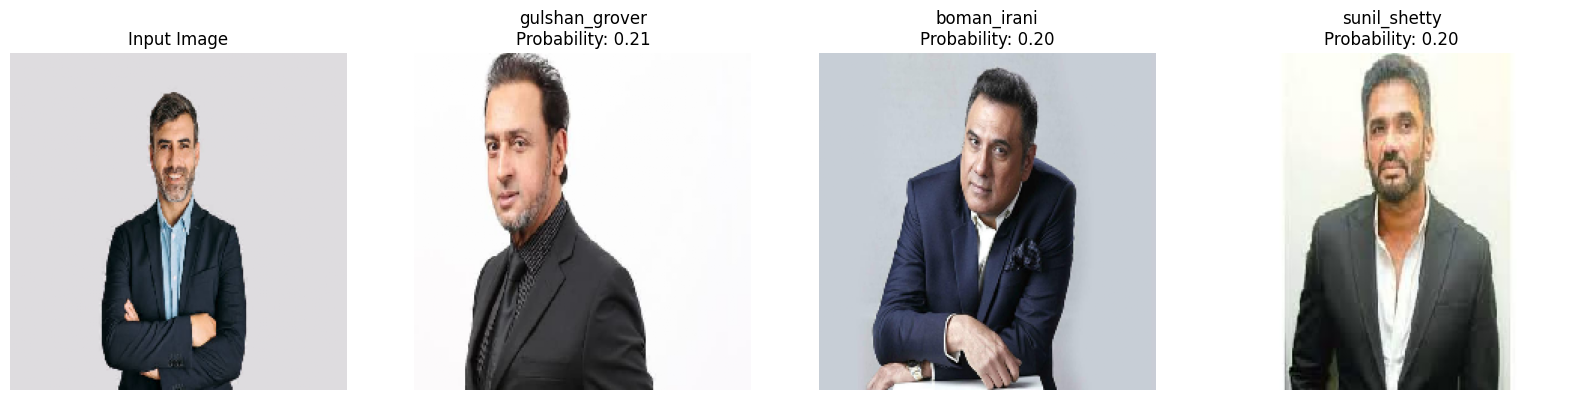

In [13]:
# Display the input image, similar actors along with probabilities
display_similar_images(input_image, similar_images, similar_image_paths, probabilities)